# Klasifikasi Gambar (Biometric - Palm)



```
# Villeneuve Andhira Suwandhi (2108067)
# Universitas Pendidikan Indonesia [IK585 - Financial Technology]
```



Notebook ini berisi langkah-langkah untuk membangun Siamese Network menggunakan Convolutional Neural Network (CNN) untuk tugas image similarity atau image verification. Fokusnya adalah pada:

1. Data Preparation:
Data gambar di-load dari folder yang mewakili kelas yang berbeda.
Setiap gambar diubah ukurannya menjadi (128, 128) dan dinormalisasi.
Gambar dibagi menjadi data latih dan data uji menggunakan train_test_split.
Dibuat pasangan gambar positif (dari kelas yang sama) dan negatif (dari kelas yang berbeda).
2. Model Architecture:
Model Siamese Network dibuat menggunakan CNN untuk menghasilkan embedding dari gambar.
CNN terdiri dari beberapa lapisan Conv2D dan MaxPooling2D, diikuti oleh lapisan Flatten dan Dense.
Embedding dari gambar dinormalisasi menggunakan L2-normalization.
Jarak antara dua embedding dihitung menggunakan Euclidean Distance untuk menentukan kesamaan antara dua gambar.
3. Training and Evaluation:
Model dilatih menggunakan pasangan gambar yang dihasilkan (dua gambar dari satu pasangan sebagai input).
Digunakan fungsi contrastive loss atau binary crossentropy untuk melatih model.
Evaluasi dilakukan menggunakan data uji untuk mengukur akurasi model dalam memprediksi apakah dua gambar serupa atau tidak.
4. Save Model:
Setelah melatih model, kita bisa menyimpan model Siamese Network menggunakan fungsi model.save().
Model yang tersimpan dapat di-load kembali untuk digunakan dalam eksperimen prediksi atau evaluasi di masa depan dengan fungsi tf.keras.models.load_model().
5. Prediction Experiment:
Setelah model dilatih dan disimpan, Anda dapat melakukan eksperimen prediksi untuk memeriksa apakah dua gambar serupa atau tidak.
Proses prediksi melibatkan:
Input dua gambar baru yang ingin diuji.
Model menghasilkan embedding untuk kedua gambar tersebut.
Jarak antara kedua embedding dihitung, dan jika jarak lebih kecil dari threshold tertentu, gambar dianggap serupa.

Tujuan Utama untuk membangun model yang dapat menentukan apakah dua gambar dalam pasangan input adalah dari kelas yang sama (positif) atau dari kelas yang berbeda (negatif).

In [16]:
# import library
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

##1. Data Preparation

In [17]:
# dataset
url_dir = "/content/drive/Othercomputers/My Laptop/7/IK585-Financial_Technology/_code/prototype-palm/ROI/session1"

In [18]:
# init
img_size = (128, 128) # ukuran gambar
column = 5 # jumlah kolom
start_index = 0  # Indeks awal
end_index = 10    # Indeks akhir
epochs = 50

In [19]:
# fungsi untuk memuat gambar dan label
def load_data(base_dir, start_index, end_index):
    # init
    x = []
    y = []
    folders = os.listdir(base_dir)

    # process
    selected_folders = folders[start_index:end_index]
    num_classes = len(selected_folders)
    folder_images = {folder: [] for folder in selected_folders}

    # loop untuk menyimpan gambar dan namanya
    for i, folder in enumerate(selected_folders):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path):
            images = os.listdir(folder_path)
            for image_file in images:
                image_path = os.path.join(folder_path, image_file)
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    img = img.astype('float32') / 255.0
                    folder_images[folder].append(img)
                    x.append(img)
                    y.append(i)

    # nilai return
    x = np.array(x)
    y = np.array(y)
    return x, y, num_classes, selected_folders, folder_images

# fungsi untuk menampilkan beberapa gambar
def display_images(folder_images, folder_names, cols):
    # init
    image_list = [images[0] for images in folder_images.values() if images]
    titles = folder_names
    rows = len(image_list) // cols + (len(image_list) % cols > 0)
    plt.figure(figsize=(15, rows * 3))

    # plot
    for i, img in enumerate(image_list):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(titles[i])
        plt.axis('off')

    # show
    plt.show()

# fungsi untuk membuat pasangan gambar dan label
def create_pairs(x, y):
    # init
    pairs = []
    labels = []

    # buat dictionary berdasarkan kelas
    class_dict = {}
    for i, label in enumerate(y):
        if label not in class_dict:
            class_dict[label] = []
        class_dict[label].append(i)

    # buat pasangan (positif dan negatif)
    num_classes = len(class_dict)
    for label in class_dict:
        class_indices = class_dict[label]
        # memastikan setidaknya ada 2 gambar
        if len(class_indices) < 2:
            continue
        # pasangan positif (dari kelas yang sama)
        for i in range(len(class_indices) - 1):
            pairs.append([x[class_indices[i]], x[class_indices[i + 1]]])
            labels.append(1)

        # pasangan negatif (dari kelas yang berbeda)
        for i in range(len(class_indices)):
            neg_label = (label + 1) % num_classes
            neg_index = np.random.choice(class_dict[neg_label])
            pairs.append([x[class_indices[i]], x[neg_index]])
            labels.append(0)

    return np.array(pairs), np.array(labels)

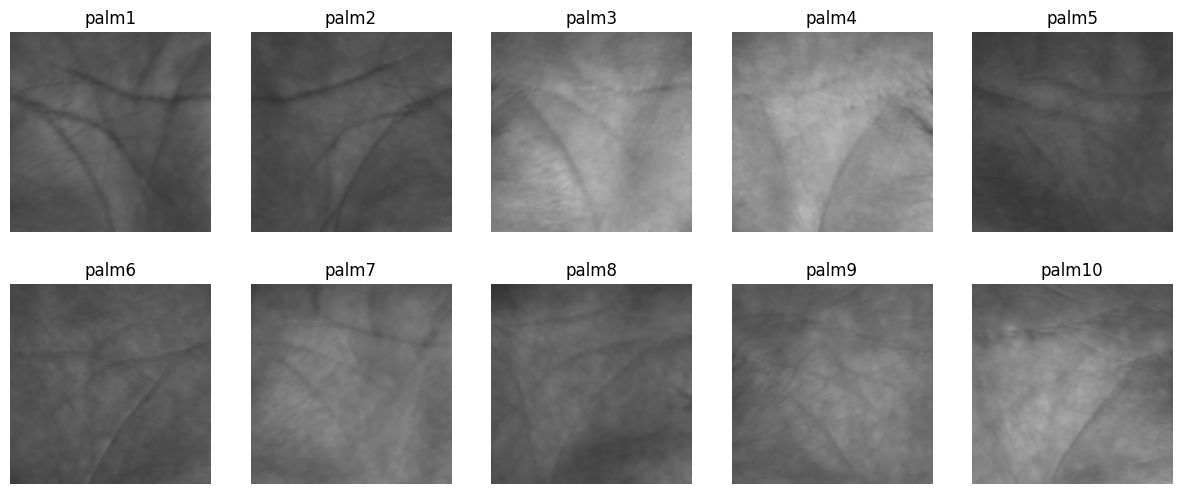

In [20]:
# load data
x, y, num_classes, folder_names, folder_images = load_data(url_dir, start_index, end_index)

# menampilkan gambar pertama dari setiap folder
display_images(folder_images, folder_names, cols=column)

In [21]:
# membuat pasangan gambar untuk pelatihan dan pengujian
x_pairs, y_pairs = create_pairs(x, y)

# split data menjadi train dan test set (80% training, 20% testing)
x_train_pairs, x_test_pairs, y_train_pairs, y_test_pairs = train_test_split(x_pairs, y_pairs, test_size=0.2, random_state=42)

# memisahkan pasangan gambar menjadi dua input dan mengubah nilai nama dalam 'float32'
x_train = [x_train_pairs[:, 0], x_train_pairs[:, 1]]
x_test = [x_test_pairs[:, 0], x_test_pairs[:, 1]]
y_train = y_train_pairs.astype('float32')
y_test = y_test_pairs.astype('float32')

# Info about the shapes of the datasets
print(f'Jumlah kelas: {num_classes}')
print(f'x_train shape: {[arr.shape for arr in x_train]}')
print(f'x_test shape: {[arr.shape for arr in x_test]}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

Jumlah kelas: 10
x_train shape: [(152, 128, 128, 3), (152, 128, 128, 3)]
x_test shape: [(38, 128, 128, 3), (38, 128, 128, 3)]
y_train shape: (152,)
y_test shape: (38,)


## 2. Model Architecture

In [22]:
# model deep learning (CNN) dengan (Siamese Network) untuk hasil embedding
def create_siamese_model(input_shape):
    # input layer
    input = Input(shape=input_shape)

    # block 1
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # block 2
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # block 3
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten and dense layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # embedding output
    embedding = Dense(128)(x)
    embedding = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embedding)

    # defining the model with a name
    model = Model(inputs=input, outputs=embedding, name="SiameseEmbeddingModel")

    return model

# Conv2D: ([jumlah filter], [ukuran filter], [fungsi aktivasi])
# MaxPooling2D: [reduksi dimensi mengurangi overfitting]
# Flatten: [meratakan ulang shape]
# Dropout: [randomly dropping out selected neurons during the training phase]
# Dense: [menghubungkan nodes]

Contrastive loss membantu model untuk meminimalkan jarak antara pasangan gambar yang serupa (positif) dan memaksimalkan jarak antara pasangan gambar yang berbeda (negatif).
Jika label pasangan adalah 1 (positif), jarak Euclidean diharapkan mendekati nol. Jika label adalah 0 (negatif), jarak Euclidean diharapkan mendekati margin tertentu.

In [23]:
# menggunakan fungsi loss
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# menggunakan
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [24]:
# input shape dan subnet
input_shape = (128, 128, 3)
base_network = create_siamese_model(input_shape)

# input untuk kedua gambar
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# menghasilkan embeddings dari kedua gambar
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# menghitung jarak antara kedua embeddings (menggunakan Euclidean Distance)
distance = Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1)))([embedding_a, embedding_b])

# membuat model Siamese dengan nama
siamese_model = Model(inputs=[input_a, input_b], outputs=distance, name="SiameseNetwork")

# kompilasi model
siamese_model.compile(
    loss=contrastive_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=[accuracy]
)

# ringkasan model
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ SiameseEmbeddingModel     │ (None, 128)            │      9,015,552 │ input_layer_7[0][0],   │
│ (Functional)              │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None)                 │              0 │ SiameseEmbeddingModel… │
│                           │                        │                │ SiameseEmbeddingModel… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,015,552 (34.39 MB)

 Trainable params: 9,015,552 (34.39 MB)

 Non-trainable params: 0 (0.00 B)

##3. Training and Evaluation

In [25]:
# callbacks: early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train the model
history = siamese_model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 16s/step - accuracy: 0.4605 - loss: 0.3400 - val_accuracy: 0.6458 - val_loss: 0.6302
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 87s 18s/step - accuracy: 0.4589 - loss: 0.2570 - val_accuracy: 0.6458 - val_loss: 0.6300
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 134s 16s/step - accuracy: 0.4748 - loss: 0.2570 - val_accuracy: 0.6458 - val_loss: 0.6300
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 16s/step - accuracy: 0.4175 - loss: 0.2457 - val_accuracy: 0.6458 - val_loss: 0.6302
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 17s/step - accuracy: 0.5062 - loss: 0.2555 - val_accuracy: 0.6458 - val_loss: 0.6302
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 78s 16s/step - accuracy: 0.5326 - loss: 0.2517 - val_accuracy: 0.6458 - val_loss: 0.6301
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 17s/step - accuracy: 0.4945 - loss: 0.2577 - val_accuracy: 0.6458 - val_loss: 0.6301
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - accuracy: 0.4785 - loss: 0.2470 - val_accuracy: 0.6458 - val_loss: 0.6300

In [26]:
# evaluasi model
test_loss, test_accuracy = siamese_model.evaluate(x_test, y_test)
print(f'Accuracy: {test_accuracy * 100:.2f}%')
print(f'Loss: {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6389 - loss: 0.6270
Accuracy: 64.58%
Loss: 0.6291969418525696


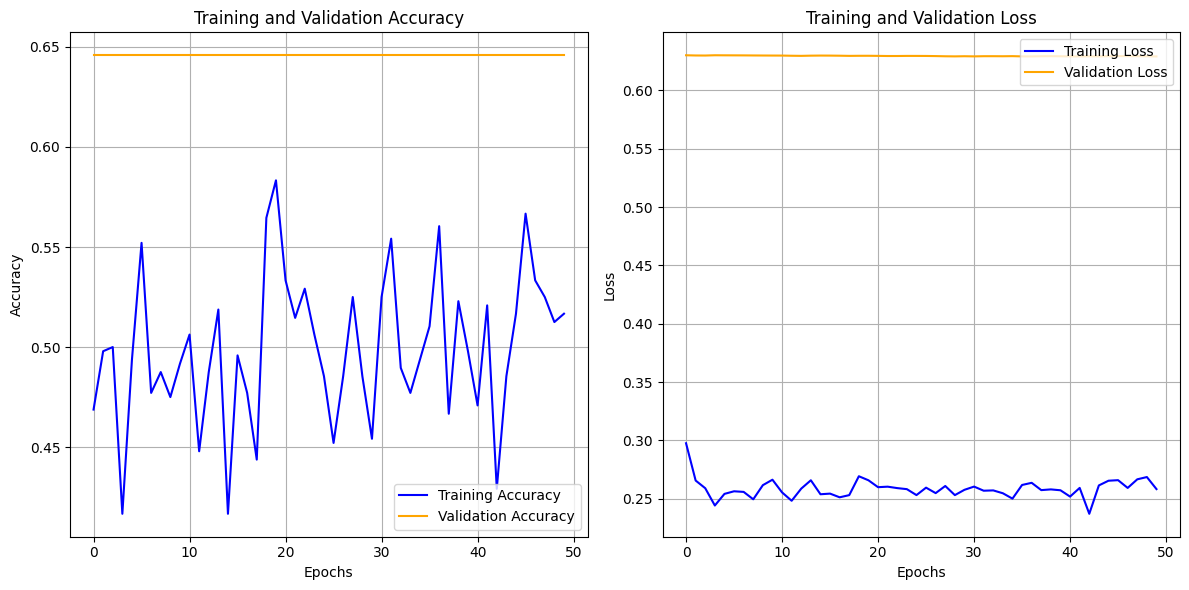

In [49]:
# assuming `history` is obtained from model.fit() and contains binary accuracy metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


## 4. Save Model

In [58]:
# save the entire model
siamese_model.save('/content/drive/MyDrive/Colab Notebooks/FINTECH/hasil-model2.keras')

In [53]:
siamese_model.load_weights('/content/drive/MyDrive/Colab Notebooks/FINTECH/hasil-model2.keras')

In [65]:
loaded_model = siamese_model

loaded_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ SiameseEmbeddingModel     │ (None, 128)            │      9,015,552 │ input_layer_7[0][0],   │
│ (Functional)              │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None)                 │              0 │ SiameseEmbeddingModel… │
│                           │                        │                │ SiameseEmbeddingModel… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,046,658 (103.17 MB)

 Trainable params: 9,015,552 (34.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 18,031,106 (68.78 MB)

## 5. Prediction experiment

In [66]:
# evaluasi model
test_loss, test_accuracy = loaded_model.evaluate(x_test, y_test)
print(f'Accuracy: {test_accuracy * 100:.2f}%')
print(f'Loss: {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 734ms/step - accuracy: 0.6389 - loss: 0.6270
Accuracy: 64.58%
Loss: 0.6291969418525696


In [69]:
# fungsi untuk mempersiapkan gambar
def prepare_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

# fungsi untuk mendapatkan nama kelas
def get_class_name(image_path):
    return os.path.basename(os.path.dirname(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
The image pair (palm7 vs palm7) is classified as 'Similar' with a similarity score of 0.0012.


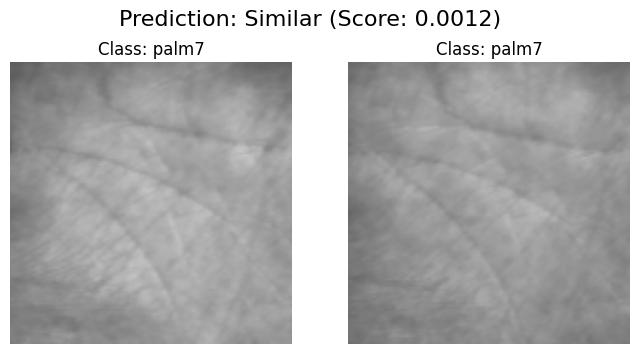

In [75]:
# mempersiapkan data test
test_name = "palm7"
folder_path = f"/content/drive/Othercomputers/My Laptop/7/IK585-Financial_Technology/_code/prototype-palm/ROI/session2/{test_name}/"
all_images = [img for img in os.listdir(folder_path) if img.endswith(('bmp'))]
if not all_images:
    raise ValueError("No images found in the specified folder.")
random_images = random.sample(all_images, 2)
image_paths = [os.path.join(folder_path, img) for img in random_images]
img_arrays = [prepare_image(image_path, (128, 128)) for image_path in image_paths]
img_arrays = np.array(img_arrays)
img1 = np.expand_dims(img_arrays[0], axis=0)
img2 = np.expand_dims(img_arrays[1], axis=0)
img_pair = [img1, img2]

# melakukan prediksi
predictions = loaded_model.predict(img_pair)
similarity_score = predictions[0]
threshold = 0.5
if similarity_score < threshold:
    result = "Similar"
else:
    result = "Not Similar"

# mendapatkan nama kelas
class_name1 = get_class_name(image_paths[0])
class_name2 = get_class_name(image_paths[1])

# hasil eksperimen
print(f"The image pair ({class_name1} vs {class_name2}) is classified as '{result}' with a similarity score of {similarity_score:.4f}.")

# visualisasi plot
plt.figure(figsize=(8, 4))
for idx, img_path in enumerate(image_paths):
    plt.subplot(1, 2, idx+1)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Class: {get_class_name(img_path)}")
plt.suptitle(f"Prediction: {result} (Score: {similarity_score:.4f})", fontsize=16)
plt.show()